np array is really faster than python list

In [138]:
import time
import random
import numpy as np
s = time.perf_counter()

cost : number of attacks (queens attack each other by being in the same row, column or diagonal)

fitness : -cost

In [139]:
class Route():
    def __init__(self):
        self.fitness = 0
        self.board = np.zeros(n)

    def cal_fitness(self):
        self.fitness = 0
        for i in range(n-1):
            for j in range(i+1, n):
                if self.board[i] == self.board[j]+(j-i) or self.board[i] == self.board[j]-(j-i) :
                    self.fitness-=1

class FirstRoute(Route) :
    def __init__(self) :
        self.fitness = 0
        self.board = np.random.permutation(n)
        

In [140]:
def best(l):
    ans = l[0]
    for r in l:
        if r.fitness>ans.fitness:
            ans = r
    return ans

def average(l):
    sum = 0
    for r in l:
        sum+=r.fitness
    return sum/(len(l))

def index_of_worst(l):
    ans = 0
    for i in range(len(l)):
        if l[i].fitness<l[ans].fitness:
            ans = i
    return ans


In [141]:
def tournament_selection(Population, m):
    k = random.randint(2,5)                #m times choose k element and return the best of k choosen element(m elements)
    def tournament(Population, k):
        index = random.sample(list(range(len(Population))), k)
        l = []
        for i in index:
            l.append(Population[i])
        return best(l)

    newPopulation = []
    for ـ in range(m):
        newPopulation.append(tournament(Population, k))

    return newPopulation

Cycle recombination works better than order recombinition. So I didn't use order recombinition

In [142]:
def Cycle_Recombination(parents):
    def get_groups(parent1,parent2):
        def sorted_union(nestedList):
            newList = []
            for list in nestedList:
                newList += list
            newList.sort()
            return newList

        def smallest_index_which_is_not_in_list(list):
            if list :
                for i in range (len(list)+1):
                    if i not in list:
                        return i
            else:
                return 0

        def recombination(groups):
            l = [-1 for _ in range(n)]
            mainParent = parent1
            for group in groups:
                for i in group:
                    l[i] = mainParent[i]
                mainParent = parent1 if np.array_equal(mainParent, parent2) else parent2
                
            ans = Route()
            ans.board = l
            ans.cal_fitness()
            return ans ;

        lO = []
        while len(sorted_union(lO)) != len(parent1) :
            startPoint = smallest_index_which_is_not_in_list(sorted_union(lO))
            lI = []
            while True:
                lI.append(startPoint)
                city2 = parent2[startPoint]
                for i,city1 in enumerate(parent1):
                    if city1 == city2:
                        startPoint = i
                        break
                    
                if startPoint in lI :
                    lO.append(lI)
                    break        

        return recombination(lO)

    
    children = []
    for _ in range(len(parents)):
        i=random.randint(0,len(parents)-2)
        children.append(get_groups(parents[i].board, parents[i+1].board))
    return children

In [143]:
def Order_recombination(parents):
    def recombination(parent1, parent2):
        def get_start_end():
            a = random.sample(list(range(n)),2 )
            a.sort()
            return a
        
        l = [-1 for _ in range(n)]
        startPoint, endPoint = get_start_end()
        for i in range(startPoint, endPoint+1):
                l[i]=parent1[i]

        j = endPoint+1 if endPoint != n-1 else 0 

        for i in range(endPoint+1, n):
            while parent2[j] in l:
                j+=1
                if j==n:
                    j = 0
            l[i]=parent2[j]
            j+=1
            if j==n:
                    j = 0

        for i in range(startPoint):
            while parent2[j] in l:
                j+=1
                if j==n:
                    j = 0
            l[i]=parent2[j]
            j+=1
            if j==n:
                    j = 0

        return l
    children = Route()
    for i in range(0,len(parents),2):
        children.board.append(recombination(parents[i].board, parents[i+1].board))
    return children

In [144]:
def swap_mutation(population, PMutation):
    def mutation(city):
        i = random.randint(0,n-1)
        j = random.randint(0,n-1)
        temp = city.board[i]
        city.board[i] = city.board[j]
        city.board[j] = temp
        city.cal_fitness()
        return city

    for _ in range(int(len(population)*PMutation)):
        i = random.randint(0,len(population)-1)
        population[i] = mutation(population[i])
    return population


In [145]:
def generational_replacement(parents,chidren, PRep):
    for _ in range (int(populationNum*PRep)):
        indexOfWorst = index_of_worst(parents)
        parents[indexOfWorst] = best(chidren)
        chidren.remove(best(chidren))
    return parents

r: neighbor radius(random very small compare to population )

i is also selected randomly and
each chromosome has n/r neighbors and is inverted from i to i + r

In [146]:
def swap(route,r):
        i = random.randint(0,n-r)
        b = Route()
        b.board = np.copy(route.board)
        b.board[i:i+r] = np.copy(np.flip(route.board[i:i+r]))
        b.cal_fitness()
        return b
    
def get_neighbours(route, r):               # r is radius
    neighbours = np.array([Route() for _ in range(n//r)])
    for i in range(n//r):
        neighbours[i] = swap(route,r)

    return neighbours

tabu search : If more than 95 genes are different, it is selected

In [147]:
import math
def tabu_search(selectedNeighbour, siblings, originalBoard):
    siblings.remove(originalBoard)
    for sibling in siblings:
        j = 0
        for i in range(n):
            if sibling.board[i] == selectedNeighbour.board[i]:
                j+=1
            if j>=int((19*n) / 20):                             #19*n/20 = 95 if n == 100
                return originalBoard
    return selectedNeighbour

def simulated_annealing(selectedNeighbour, originalBoard, averageFitness):
    delta = selectedNeighbour.fitness - originalBoard.fitness
    if delta>=0 :
        return selectedNeighbour
    elif math.exp(delta/averageFitness) > random.uniform(0,1):
        return selectedNeighbour
    return originalBoard

def kth_best(boards, k):
        for i in range(k-1):
            j = 0
            for u in range(len(boards)):
                if boards[u].fitness > boards[j].fitness :
                    j = u
            del boards[j]
            
        j = 0
        for i in range(len(boards)):
            if boards[i].fitness > boards[j].fitness :
                j = i
        return boards[j]
    
def local_search(siblings, neighbours, originalBoard):
    k = random.randint(1,5)
    kthBest = kth_best(neighbours,k)
    
    if random.randint(0,1):
        return tabu_search(kthBest, siblings[:], originalBoard)
            
    return simulated_annealing(kthBest, originalBoard, average(siblings))

In [148]:
def memetic(selectedNeighbour, originalBoard) :
    def lamarcian():
        return selectedNeighbour
    def baldwinidan():
        originalBoard.fitness = selectedNeighbour.fitness
        return originalBoard

    return lamarcian() if random.randint(0,1) else baldwinidan()

In [149]:
def improve(parents, r) :
    for i in range(len(parents)):
        neighbours = list(get_neighbours(parents[i],r))      
        selectedNeighbour = local_search(parents,neighbours, parents[i])
        
        if not np.array_equal(selectedNeighbour.board, parents[i].board):
            parents[i] = memetic(selectedNeighbour, parents[i])
    return parents

In [150]:
def plot(aveIter, bestIter):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    data = pd.DataFrame({"avegrage":aveIter, "best":bestIter})
    # plt.xlabel('generation', fontsize = 15)
    # plt.ylabel('fitness', fontsize = 15)
    data.plot()
    
    print(time.perf_counter()-s)

If we use Memetic algorithm twice, it will be slower

In [151]:
def main(n,firstPopulationNum, populationNum,PMutation,PRep):
    firstPopulation = np.array([FirstRoute() for _ in range(firstPopulationNum)]) #step1: generate the initial population
    for i in range(firstPopulationNum):
        firstPopulation[i] = FirstRoute()
        firstPopulation[i].cal_fitness()                                          #step2: compute first population fitness
    parents = firstPopulation
    bestIter = []
    aveIter = []
    bestIter.append(best(parents).fitness)
    aveIter.append(average(parents))

    while bestIter[-1] !=0 :                                                      #step8: REPEAT

        bestIter.append(best(parents).fitness)
        aveIter.append(average(parents))

        parents = tournament_selection(parents, populationNum)                    #step3: select

        children = Cycle_Recombination(parents)                                   #step4: recombination
        children = improve(children, random.randint(2,n//5))                      #step5: use memetc algorithm
        children = swap_mutation(children,PMutation)                              #step5: mutation
        # children = improve(children, random.randint(2,n//10))                   #step5: use memetc algorithm
        parents = generational_replacement(parents, children, PRep)               #step7: replacement 
        print(bestIter[-1], aveIter[-1])
        
    print("ans:",bestIter[-1], aveIter[-1], best(parents).board)
    plot(aveIter, bestIter)


-50 -66.63666666666667
-47 -59.04
-42 -55.79
-42 -50.63
-42 -47.51
-42 -45.83
-40 -43.56
-38 -42.12
-38 -41.09
-36 -39.55
-35 -37.95
-35 -37.48
-30 -36.86
-30 -35.17
-30 -34.27
-29 -32.11
-29 -30.22
-29 -29.97
-29 -29.79
-28 -29.51
-28 -29.15
-27 -28.93
-27 -28.52
-26 -27.86
-25 -27.27
-25 -26.7
-23 -26.08
-23 -25.28
-23 -24.23
-21 -23.26
-21 -22.87
-21 -22.56
-17 -21.82
-17 -20.58
-16 -20.06
-16 -19.47
-16 -18.3
-16 -16.93
-15 -16.02
-15 -15.82
-15 -15.44
-15 -15.11
-15 -15.0
-15 -15.0
-15 -15.01
-15 -15.0
-15 -15.0
-15 -15.0
-15 -15.0
-15 -15.0
-15 -15.0
-15 -15.01
-15 -15.0
-14 -14.99
-14 -14.97
-13 -14.83
-13 -14.56
-13 -13.96
-13 -13.95
-13 -13.66
-12 -13.28
-12 -12.97
-11 -12.79
-11 -12.5
-11 -12.12
-10 -11.46
-9 -11.04
-9 -10.85
-9 -10.42
-9 -10.11
-9 -9.97
-9 -9.71
-9 -9.41
-9 -9.0
-9 -9.0
-8 -8.99
-8 -8.97
-8 -8.92
-8 -8.72
-8 -8.08
-8 -8.0
-8 -8.0
-7 -7.99
-7 -7.92
-7 -7.63
-7 -7.07
-7 -7.0
-7 -7.01
-7 -7.0
-7 -7.0
-7 -7.0
-7 -7.0
-7 -7.0
-7 -7.01
-7 -7.0
-7 -7.0
-7 -7.0
-7 -

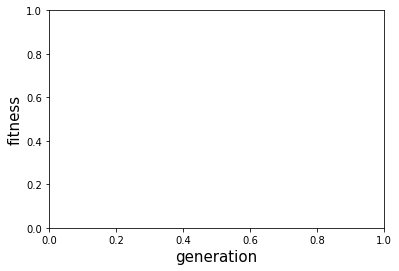

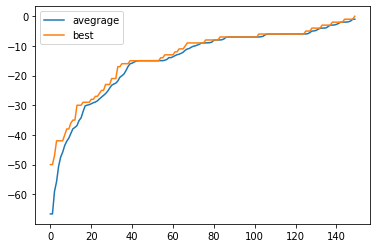

In [152]:
n = 100
firstPopulationNum = 300
populationNum = 100
PMutation = 0.65
PRep = 0.06
main(n,firstPopulationNum, populationNum,PMutation,PRep)

In [13]:
def show(board):
    import matplotlib.pyplot as plt
    import numpy as np
    chess = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if (j+i)%2 :
                chess[i][j] = -1
    for i in range(n):
        chess[i][board[i]]= 1
    # print(chess)
    plt.figure(figsize=(n,n))
    plt.imshow(chess,cmap='gray')
    plt.axis(False)
    plt.show()

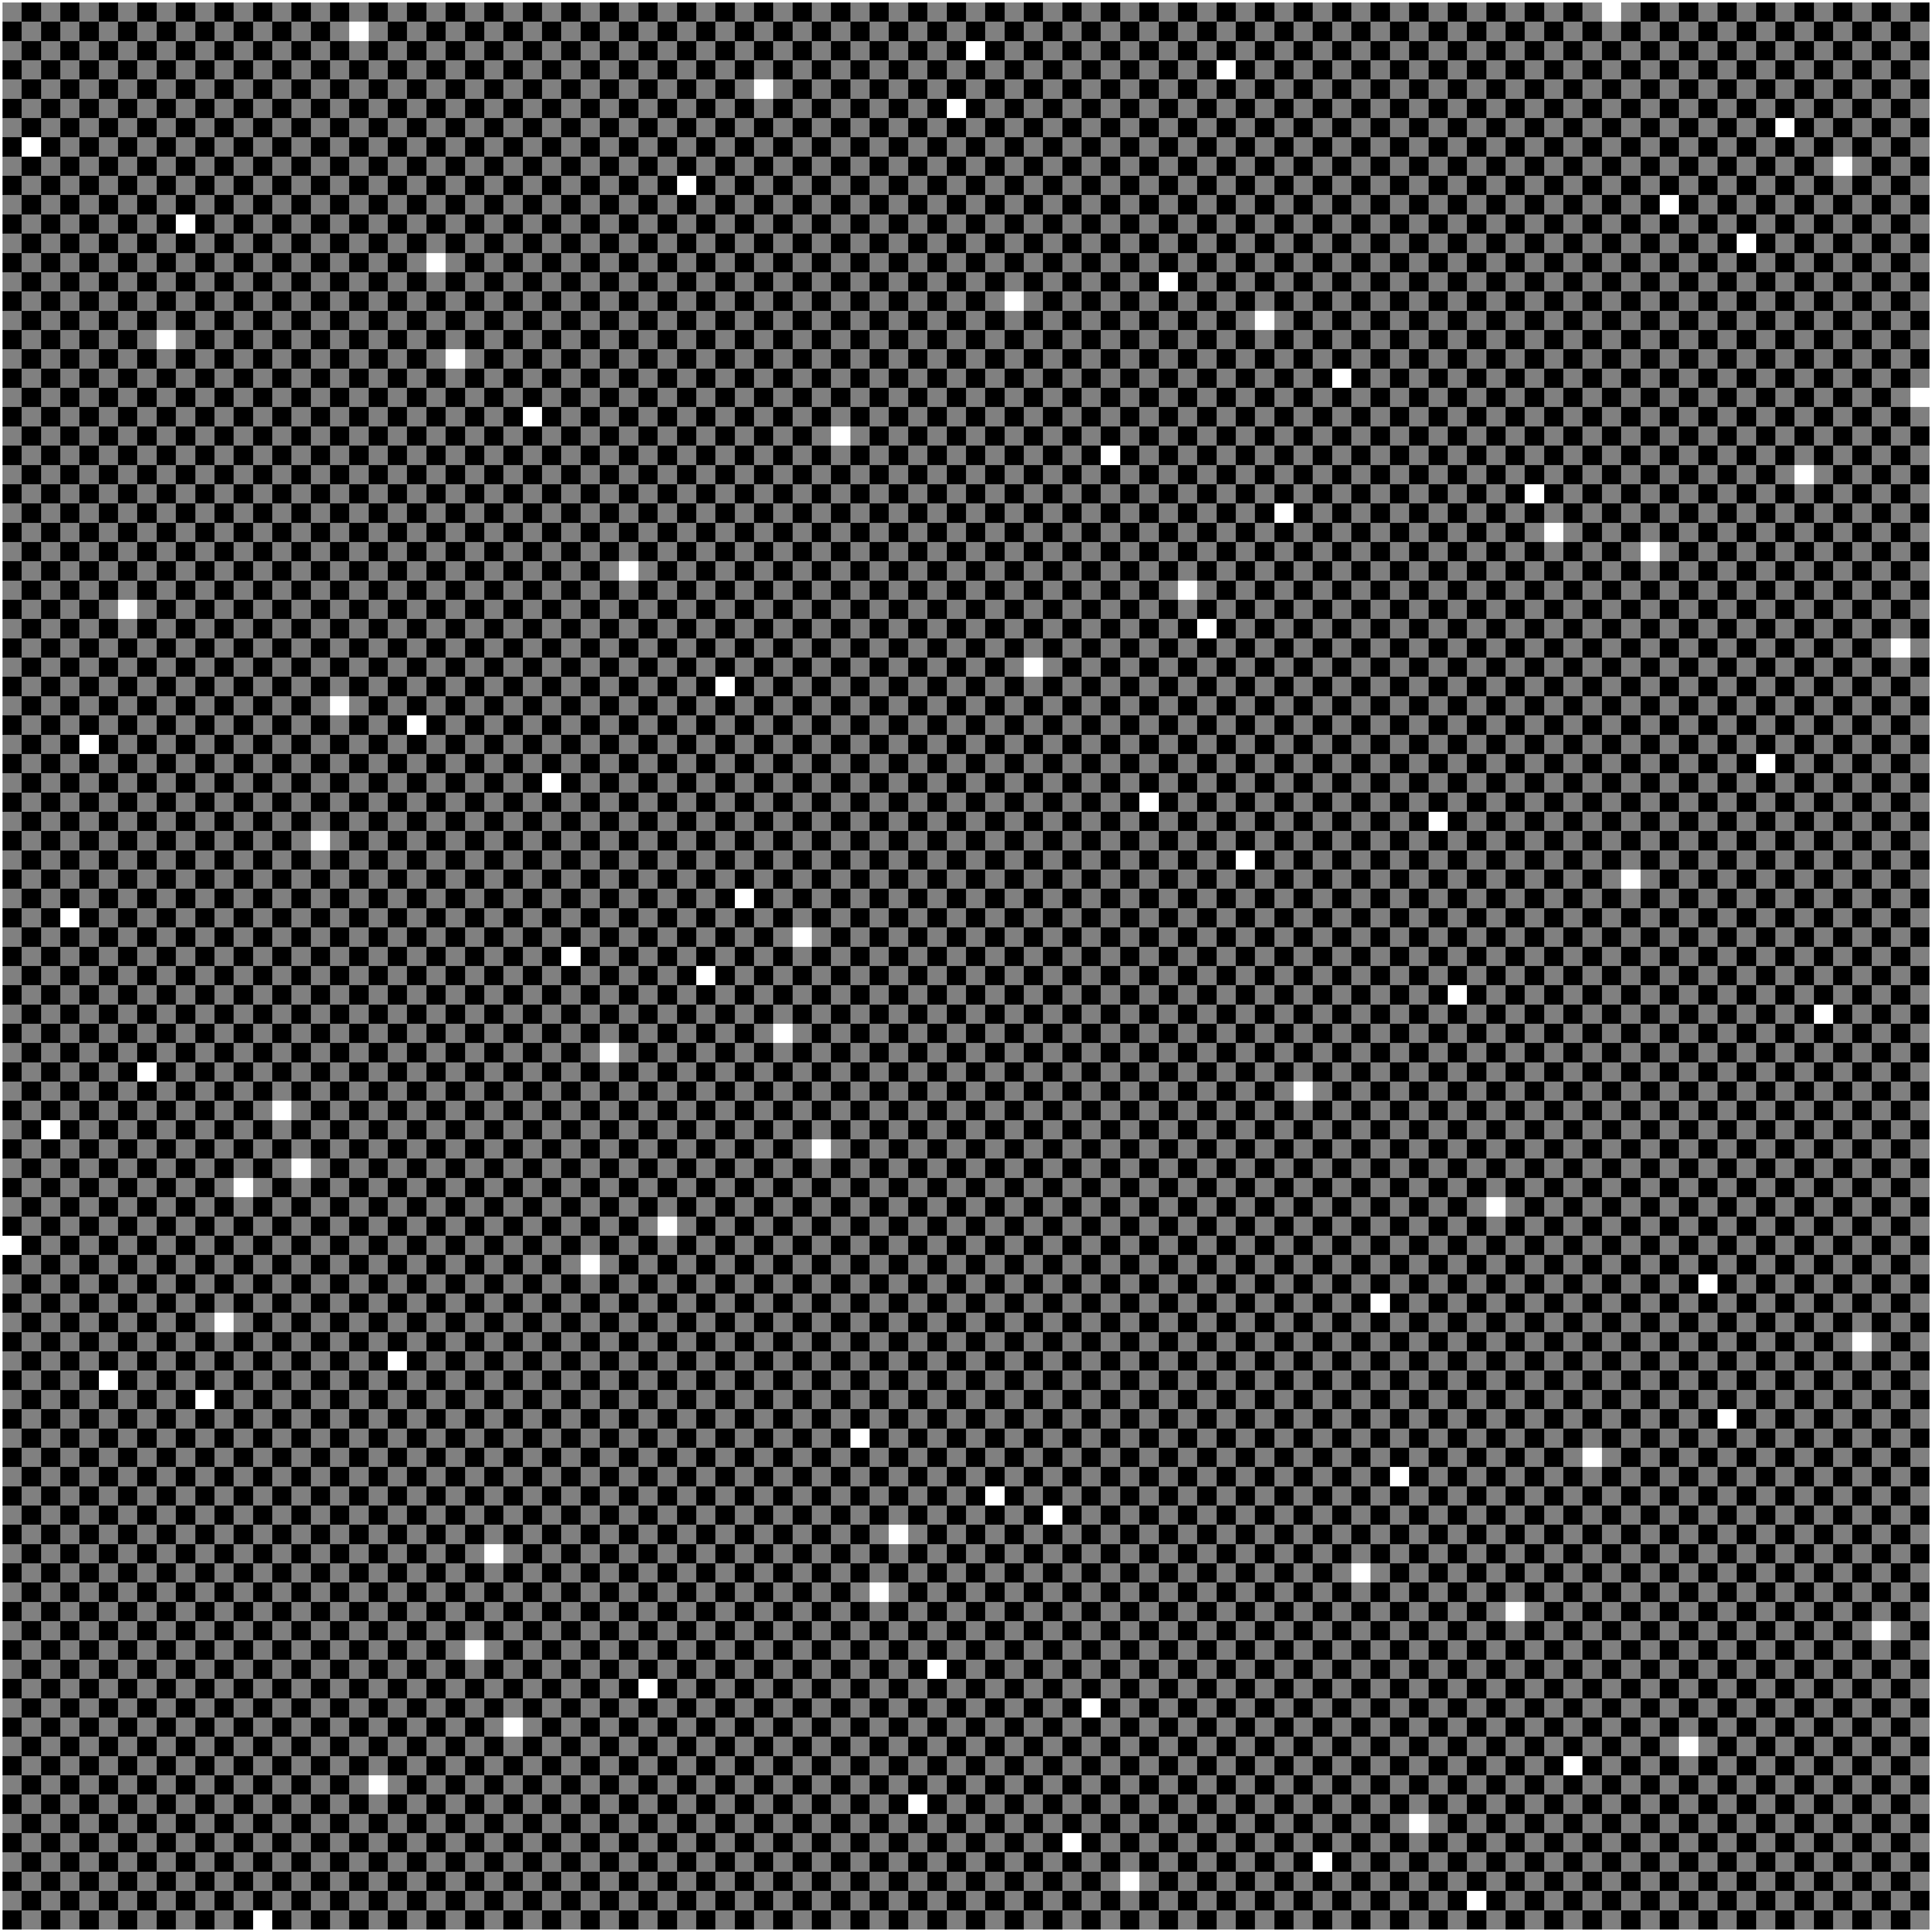

In [14]:
n=100
ansBoard = [83, 18, 50, 63, 39, 49, 92, 1, 95, 35, 86, 9, 90, 22, 60, 52, 65, 8, 23, 69, 99, 27, 43, 57, 93, 
            79, 66, 80, 85, 32, 61, 6, 62, 98, 53, 37, 17, 21, 4, 91, 28, 59, 74, 16, 64, 84, 38, 3, 41, 29, 
            36, 75, 94, 40, 31, 7, 67, 14, 2, 42, 15, 12, 77, 34, 0, 30, 88, 71, 11, 96, 20, 5, 10, 89, 44, 
            82, 72, 51, 54, 46, 25, 70, 45, 78, 97, 24, 48, 33, 56, 26, 87, 81, 19, 47, 73, 55, 68, 58, 76, 13]
show(ansBoard)